In [1]:
!pip install optuna

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import optuna

pd.options.mode.chained_assignment = None

Загрузка данных

In [3]:
filepath = "discounts_raw.csv"
discounts_df = pd.read_csv(filepath)
discounts_df

,item_id,promo_typeCode,sale_price_before_promo,sale_price_time_promo,date_start,date_end
0,100551,5.0,159.9,139.9,2023-03-02,2023-03-15
1,100553,5.0,159.9,139.9,2023-03-02,2023-03-15
2,100554,5.0,159.9,139.9,2023-03-02,2023-03-15
3,100558,5.0,159.9,139.9,2023-03-02,2023-03-15
4,100530,2.0,36.9,24.6,2021-09-09,2021-09-22
...,...,...,...,...,...,...
2076,100471,10.0,71.9,49.9,2023-05-25,2023-06-07
2077,100469,5.0,69.9,44.9,2023-11-07,2023-11-22
2078,100470,5.0,69.9,44.9,2023-11-07,2023-11-19
2079,100471,5.0,69.9,44.9,2023-11-07,2023-11-19


In [4]:
filepath = "sales_raw.csv"
sales_df = pd.read_csv(filepath)
sales_df

,date,item_id,qnty
0,2017-01-01,100001,7.0
1,2017-01-01,100003,2.0
2,2017-01-01,100006,13.0
3,2017-01-01,100010,5.0
4,2017-01-01,100035,53.0
...,...,...,...
147138,2023-12-31,100614,5.0
147139,2023-12-31,100140,4.0
147140,2023-12-31,100650,11.0
147141,2023-12-31,100182,1.0


Перевожу дату в формат даты. Сортирую датафреймы по дате.

In [5]:
discounts_df["date_start"] = pd.to_datetime(discounts_df["date_start"])
discounts_df["date_end"] = pd.to_datetime(discounts_df["date_end"])
sales_df["date"] = pd.to_datetime(sales_df["date"])

sales_df.sort_values("date", inplace=True)
discounts_df.sort_values("date_start", inplace=True)

In [6]:
discounts_df

,item_id,promo_typeCode,sale_price_before_promo,sale_price_time_promo,date_start,date_end
63,100645,5.0,99.9,59.9,2020-01-02,2020-01-08
585,100558,7.0,139.9,85.0,2020-01-02,2020-01-08
584,100556,7.0,139.9,85.0,2020-01-02,2020-01-08
583,100554,7.0,139.9,85.0,2020-01-02,2020-01-08
582,100553,7.0,139.9,85.0,2020-01-02,2020-01-08
...,...,...,...,...,...,...
1009,100375,6.0,279.9,199.9,2024-02-01,2024-02-14
517,100683,6.0,239.9,169.9,2024-02-01,2024-02-14
1653,100545,44.0,229.9,189.9,2024-02-01,2024-02-14
1651,100370,44.0,499.9,279.9,2024-02-01,2024-02-14


In [7]:
sales_df

,date,item_id,qnty
0,2017-01-01,100001,7.0
25,2017-01-01,100524,4.0
26,2017-01-01,100525,1.0
27,2017-01-01,100526,4.0
28,2017-01-01,100528,3.0
...,...,...,...
147106,2023-12-31,100257,9.0
147107,2023-12-31,100621,7.0
147108,2023-12-31,100473,1.0
147110,2023-12-31,100602,11.0


Выбираю товары, участвовашие в продажах в декабре

In [8]:
items_dec = sales_df[sales_df["date"] >= '2023-12']["item_id"].value_counts().index.values
items_dec

array([100510, 100601, 100590, 100035, 100523, 100604, 100165, 100346,
       100470, 100001, 100003, 100602, 100611, 100010, 100612, 100607,
       100245, 100524, 100455, 100553, 100528, 100646, 100487, 100257,
       100614, 100621, 100639, 100473, 100448, 100454, 100526, 100259,
       100545, 100182, 100638, 100645, 100691, 100551, 100613, 100474,
       100188, 100591, 100140, 100516, 100228, 100453, 100471, 100547,
       100450, 100006, 100544, 100176, 100184, 100650, 100354, 100683,
        11200, 100517, 100486, 100193, 100656, 100386, 100192, 100556,
       100417, 100462, 100390, 100469, 100596, 100558, 100686, 100648,
       100126, 100370, 100227, 100375, 100651, 100525, 100644, 100348,
       100554, 100394, 100045, 100664, 100668, 100657, 100139, 100225,
       100181, 100050, 100046, 100663, 100418, 100399, 100530, 100665,
       100662])

In [9]:
sales_df_dec = sales_df[sales_df["item_id"].isin(items_dec)].sort_values('date').reset_index(drop=True)
discounts_df_dec = discounts_df[discounts_df["item_id"].isin(items_dec)].sort_values('date_start').reset_index(drop=True)
sales_df_dec

,date,item_id,qnty
0,2017-01-01,100001,7.0
1,2017-01-01,100257,1.0
2,2017-01-01,100003,2.0
3,2017-01-01,100006,13.0
4,2017-01-01,100010,5.0
...,...,...,...
144929,2023-12-31,100650,11.0
144930,2023-12-31,100453,1.0
144931,2023-12-31,100558,16.0
144932,2023-12-31,100050,1.0


Добавляю явнварь 2024 для рассчета цены

In [10]:
additional_dates = pd.date_range(start='2024-01-01', end='2024-01-31', freq='D')

# Создаем новый DataFrame с дополнительными датами и None в качестве quantity
additional_data = pd.DataFrame({
    'item_id': pd.concat([pd.Series(items_dec)] * len(additional_dates)),
    'date': additional_dates.repeat(len(items_dec)).sort_values(),
    'qnty': [None] * len(additional_dates) * len(items_dec)
})

# Объединяем новый DataFrame с существующими данными
sales_df_dec = pd.concat([sales_df_dec, additional_data]).sort_values(by='date').reset_index(drop=True)
sales_df_dec

,date,item_id,qnty
0,2017-01-01,100001,7.0
1,2017-01-01,100510,3.0
2,2017-01-01,100524,4.0
3,2017-01-01,100525,1.0
4,2017-01-01,100526,4.0
...,...,...,...
147936,2024-01-31,100473,NaN
147937,2024-01-31,100639,NaN
147938,2024-01-31,100621,NaN
147939,2024-01-31,100487,NaN


Кодирую id продуктов LabelEncoder'ом

In [11]:
label_encoder = LabelEncoder()

sales_df_dec["item_id_encoded"] = label_encoder.fit_transform(sales_df_dec["item_id"])
discounts_df_dec["item_id_encoded"] = label_encoder.transform(discounts_df_dec["item_id"])
sales_df_dec.sort_values("item_id_encoded")

,date,item_id,qnty,item_id_encoded
40838,2018-12-03,11200,211.0,0
83521,2021-01-05,11200,254.0,0
108743,2022-03-29,11200,334.0,0
108708,2022-03-28,11200,365.0,0
138252,2023-09-14,11200,289.0,0
...,...,...,...,...
84176,2021-01-17,100691,5.0,96
96464,2021-08-23,100691,3.0,96
34759,2018-08-20,100691,2.0,96
84309,2021-01-19,100691,1.0,96


In [12]:
discounts_df_dec

,item_id,promo_typeCode,sale_price_before_promo,sale_price_time_promo,date_start,date_end,item_id_encoded
0,100645,5.0,99.9,59.9,2020-01-02,2020-01-08,82
1,100544,5.0,159.9,99.9,2020-01-02,2020-01-08,59
2,100638,5.0,99.9,59.9,2020-01-02,2020-01-08,79
3,100545,5.0,159.9,99.9,2020-01-02,2020-01-08,60
4,100417,6.0,49.9,37.9,2020-01-02,2020-01-08,35
...,...,...,...,...,...,...,...
2027,100394,6.0,169.9,119.9,2024-02-01,2024-02-14,33
2028,100390,6.0,169.9,119.9,2024-02-01,2024-02-14,32
2029,100544,44.0,229.9,189.9,2024-02-01,2024-02-14,59
2030,100556,5.0,159.9,159.9,2024-02-01,2024-02-14,65


In [13]:
discounts_df_dec = discounts_df_dec.sort_values(["item_id", "date_start"]).reset_index(drop=True)

Рассчет цены

In [14]:
# Добавляю столбец с датой следующей сделки
discounts_df_dec["start_next_promo"] = discounts_df_dec["date_start"].shift(-1)
# Добавляю столбец с ценой до начала следующей сделки
discounts_df_dec["sale_price_after_promo"] = discounts_df_dec["sale_price_before_promo"].shift(-1)

discounts_df_dec.loc[discounts_df_dec.groupby('item_id').tail(1).index, 'start_next_promo'] = np.nan
discounts_df_dec.loc[discounts_df_dec.groupby('item_id').tail(1).index, 'sale_price_after_promo'] = np.nan

In [15]:
discounts_df_dec[:20]

,item_id,promo_typeCode,sale_price_before_promo,sale_price_time_promo,date_start,date_end,item_id_encoded,start_next_promo,sale_price_after_promo
0,100045,5.0,599.9,499.9,2020-08-20,2020-09-09,6,2020-09-10,599.9
1,100045,6.0,599.9,499.9,2020-09-10,2020-09-28,6,2020-09-29,599.9
2,100045,5.0,599.9,499.9,2020-09-29,2020-10-21,6,2020-10-22,599.9
3,100045,6.0,599.9,499.9,2020-10-22,2020-11-09,6,NaT,NaN
4,100046,6.0,339.9,299.9,2021-01-14,2021-01-25,7,2021-07-06,349.9
5,100046,6.0,349.9,299.9,2021-07-06,2021-07-26,7,2022-01-11,349.9
6,100046,6.0,349.9,309.9,2022-01-11,2022-01-24,7,NaT,NaN
7,100050,6.0,259.9,224.9,2021-01-26,2021-02-08,8,2021-05-05,259.9
8,100050,6.0,259.9,224.9,2021-05-05,2021-05-24,8,2021-09-28,259.9
9,100050,6.0,259.9,224.9,2021-09-28,2021-10-18,8,NaT,NaN


In [16]:
# Функция для определения цены с учетом даты
def get_price(df_sale):

    date_sale = df_sale["date"]
    item = df_sale["item_id_encoded"]
    for _, row in discounts_df_dec[discounts_df_dec["item_id_encoded"] == item].iterrows():
        # Обрабатываю случай когда продукт продавался до первой акции на него.
        if row['date_start'] > date_sale:
            return row['sale_price_before_promo']
        else:

          if row['date_start'] <= date_sale <= row['date_end']:
              return row['sale_price_time_promo']
          else:

            if row['date_end'] < date_sale < row['start_next_promo']:
              return row['sale_price_after_promo']

    return None

sales_df_dec["price"] = sales_df_dec.apply(lambda row: get_price(row), axis=1)
sales_df_dec

,date,item_id,qnty,item_id_encoded,price
0,2017-01-01,100001,7.0,1,NaN
1,2017-01-01,100510,3.0,50,NaN
2,2017-01-01,100524,4.0,54,89.9
3,2017-01-01,100525,1.0,55,89.9
4,2017-01-01,100526,4.0,56,89.9
...,...,...,...,...,...
147936,2024-01-31,100473,NaN,46,49.9
147937,2024-01-31,100639,NaN,80,NaN
147938,2024-01-31,100621,NaN,78,119.9
147939,2024-01-31,100487,NaN,49,NaN


Обработка NaN

In [17]:
sales_df_dec["price"] = sales_df_dec.fillna(sales_df_dec.groupby("item_id").transform("mean"))["price"]
sales_df_dec = sales_df_dec[sales_df_dec["price"].notna()]
sales_df_dec

,date,item_id,qnty,item_id_encoded,price
2,2017-01-01,100524,4.0,54,89.900000
3,2017-01-01,100525,1.0,55,89.900000
4,2017-01-01,100526,4.0,56,89.900000
5,2017-01-01,100528,3.0,57,89.900000
6,2017-01-01,100554,6.0,64,139.900000
...,...,...,...,...,...
147936,2024-01-31,100473,NaN,46,49.900000
147937,2024-01-31,100639,NaN,80,72.011870
147938,2024-01-31,100621,NaN,78,119.900000
147939,2024-01-31,100487,NaN,49,53.155249


Смотрю изменение цены по годам

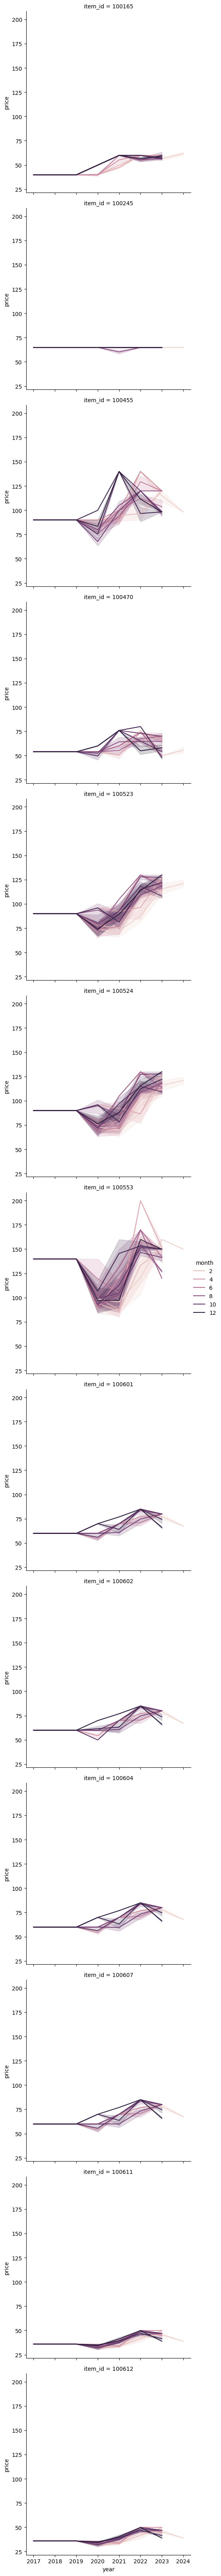

In [18]:
tmp = sales_df_dec[sales_df_dec["item_id"].isin(items_dec[:20])].copy()
tmp["year"] = tmp["date"].dt.year
tmp["month"] = tmp["date"].dt.month
sns.relplot(data=tmp, x="year", y="price", hue="month", row="item_id", kind="line")

Убираю сделки до 2019 года, т.к. их цена неинформативна

In [19]:
sales_df_dec = sales_df_dec[sales_df_dec["date"] >= '2019'].reset_index(drop=True)
sales_df_dec

,date,item_id,qnty,item_id_encoded,price
0,2019-01-01,100526,1.0,56,89.900000
1,2019-01-01,100545,1.0,60,159.900000
2,2019-01-01,100556,19.0,65,139.900000
3,2019-01-01,100638,1.0,79,99.900000
4,2019-01-01,100553,17.0,63,139.900000
...,...,...,...,...,...
86427,2024-01-31,100473,NaN,46,49.900000
86428,2024-01-31,100639,NaN,80,72.011870
86429,2024-01-31,100621,NaN,78,119.900000
86430,2024-01-31,100487,NaN,49,53.155249


Создаю датасет

In [24]:
X_train = sales_df_dec[sales_df_dec["date"] < pd.to_datetime("2023-12-01")]
X_train["wd"] = X_train["date"].dt.weekday
y_train = X_train["qnty"]
X_train.drop(columns=["qnty", "date", "item_id"], axis=1, inplace=True)

X_test = sales_df_dec[(sales_df_dec["date"] >= pd.to_datetime("2023-12-01")) & (sales_df_dec["date"] <= pd.to_datetime("2023-12-31"))]
X_test["wd"] = X_test["date"].dt.weekday
y_test = X_test["qnty"]
X_test.drop(columns=["qnty", "date", "item_id"], axis=1, inplace=True)

In [25]:
X_test

,item_id_encoded,price,wd
82272,62,149.900000,4
82273,54,129.900000,4
82274,23,64.809385,4
82275,76,37.747304,4
82276,59,169.900000,4
...,...,...,...
83885,9,419.900000,6
83886,7,341.447619,6
83887,22,106.413587,6
83888,74,38.893830,6


In [26]:
y_test

82272     3.0
82273     4.0
82274     5.0
82275     1.0
82276     7.0
         ... 
83885     5.0
83886     1.0
83887     2.0
83888    63.0
83889     6.0
Name: qnty, Length: 1618, dtype: float64

In [27]:
models = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge()),
    ('Lasso Regression', Lasso()),
    ('K-Nearest Neighbors', KNeighborsRegressor()),
    ('XGBoost', XGBRegressor()),

]

for model_name, model in models:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', model)
    ])

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    rmse =mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    print(f'Модель: {model_name}')
    print(f'RMSE: {rmse}')
    print(f"R2: {r2}")
    print("-"*50)

Модель: Linear Regression
RMSE: 8.231304828575444
R2: 0.0015654348385842898
--------------------------------------------------
Модель: Ridge Regression
RMSE: 8.231301098451521
R2: 0.001566339745860068
--------------------------------------------------
Модель: Lasso Regression
RMSE: 8.19806965348495
R2: 0.009611827777795123
--------------------------------------------------
Модель: K-Nearest Neighbors
RMSE: 8.123629103706417
R2: 0.027516120401305244
--------------------------------------------------
Модель: XGBoost
RMSE: 7.605292830651874
R2: 0.14765755015212523
--------------------------------------------------


Лучше всего показывает себя модель XGBOOST, попробую оптимизировать ее параметры

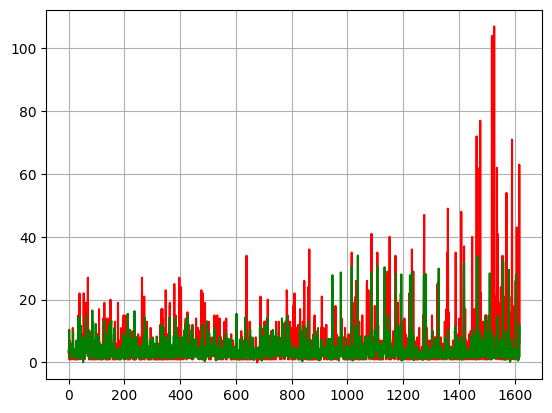

In [28]:
plt.plot(y_test.reset_index(drop=True), color = 'red')
plt.plot(y_pred, color = 'green')

plt.grid()

plt.show()

In [29]:
def objective(trial):
    # Определение гиперпараметров, которые будет подбирать Optuna
    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'booster': 'gbtree',
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.6, 0.7, 0.8, 0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 0.9, 1.0]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'eta': trial.suggest_float('eta', 1e-8, 1.0, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
    }

    # Создание и обучение модели
    model = XGBRegressor(**param, random_state=42)
    model.fit(X_train, y_train)

    # Предсказание и оценка RMSE
    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)

    return rmse

In [30]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Печать наилучших гиперпараметров и значений
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-07-23 11:11:21,389] A new study created in memory with name: no-name-6724ab34-3b39-426f-9d35-9af68ee3c85c
[I 2024-07-23 11:11:22,718] Trial 0 finished with value: 7.567444455178041 and parameters: {'lambda': 0.00010719694951945592, 'alpha': 4.310799826815139e-05, 'colsample_bytree': 0.6, 'subsample': 0.9, 'learning_rate': 0.020559523605245874, 'n_estimators': 293, 'max_depth': 6, 'min_child_weight': 3, 'eta': 6.375864125760094e-07, 'gamma': 4.175001738615754e-08, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 7.567444455178041.
[I 2024-07-23 11:11:23,557] Trial 1 finished with value: 7.540271941708774 and parameters: {'lambda': 4.220955183005735e-07, 'alpha': 0.18714232795187347, 'colsample_bytree': 0.8, 'subsample': 0.9, 'learning_rate': 0.011385620197794454, 'n_estimators': 116, 'max_depth': 8, 'min_child_weight': 3, 'eta': 0.017687010265373365, 'gamma': 0.0263085895541436, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 7.540271941708774.
[I 2024-07-23 11:

Best trial:
  Value: 7.291960307833529
  Params: 
    lambda: 0.002710562609254929
    alpha: 0.09735710037454524
    colsample_bytree: 0.8
    subsample: 1.0
    learning_rate: 0.08614330476120567
    n_estimators: 667
    max_depth: 5
    min_child_weight: 8
    eta: 0.012748653783488703
    gamma: 0.0002636417053173463
    grow_policy: lossguide


In [31]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', XGBRegressor(**trial.params))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'Модель: {model_name}')
print(f'RMSE: {rmse}')
print(f"R2: {r2}")
print("-"*50)

Модель: XGBoost
RMSE: 7.3231943742890655
R2: 0.20971568907150384
--------------------------------------------------


In [35]:
jan_data = sales_df_dec[sales_df_dec["date"] > pd.to_datetime("2023-12-31")]
jan_data["wd"] = jan_data["date"].dt.weekday
jan_data

,date,item_id,qnty,item_id_encoded,price,wd
83890,2024-01-01,100556,NaN,65,159.900000,0
83891,2024-01-01,100417,NaN,35,49.748527,0
83892,2024-01-01,100462,NaN,42,86.582616,0
83893,2024-01-01,100469,NaN,43,55.107341,0
83894,2024-01-01,100596,NaN,69,99.900000,0
...,...,...,...,...,...,...
86427,2024-01-31,100473,NaN,46,49.900000,2
86428,2024-01-31,100639,NaN,80,72.011870,2
86429,2024-01-31,100621,NaN,78,119.900000,2
86430,2024-01-31,100487,NaN,49,53.155249,2


In [36]:
jan_data["prediction"] = pipeline.predict(jan_data[["item_id_encoded", "price", "wd"]])
jan_data["item_id"] = label_encoder.inverse_transform(jan_data["item_id_encoded"])
jan_data.sort_values(["date", "item_id"], inplace=True, ignore_index=True)

In [37]:
jan_data

,date,item_id,qnty,item_id_encoded,price,wd,prediction
0,2024-01-01,100045,NaN,6,591.675701,0,1.508943
1,2024-01-01,100046,NaN,7,341.447619,0,1.722849
2,2024-01-01,100050,NaN,8,258.740361,0,1.536687
3,2024-01-01,100126,NaN,9,419.900000,0,1.383688
4,2024-01-01,100139,NaN,10,749.900000,0,1.171263
...,...,...,...,...,...,...,...
2537,2024-01-31,100665,NaN,92,99.900000,2,1.506140
2538,2024-01-31,100668,NaN,93,175.876623,2,1.347551
2539,2024-01-31,100683,NaN,94,239.900000,2,1.377981
2540,2024-01-31,100686,NaN,95,289.900000,2,2.102221


In [38]:
jan_data[["date", "item_id", "prediction"]].to_csv('predictions.csv', sep=';', index=False)